## Import

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0, 1"
import cv2
import pandas as pd
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
import time
import albumentations as A
import random

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/mmc/anaconda3/envs/Satellitef/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def set_seed(seed=7777):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # CuDNN을 사용할 때의 시드 고정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # CuBLAS와 CuDNN 연산 시에도 동일한 결과를 얻을 수 있도록 설정
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False

set_seed(7777)

## Utils

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [4]:
"""Datasets
"""

class SegDataset(Dataset):
    """Dataset for image segmentation"""

    def __init__(self, csv, transform=None, mode='train', logger=None, verbose=False):
        self.logger = logger
        self.verbose = verbose
        self.mode = mode
        self.transform = transform
        self.data = []
        
        if self.mode in ['train', 'valid']:
            for _, row in csv.iterrows():
                image_path = row['img_path']
                mask_path = row['mask_path']
                self.data.append((image_path, mask_path))
            
        elif self.mode in ['test']:
            for _, row in csv.iterrows():
                image_path = row['img_path']
                self.data.append(image_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        if self.mode in ['train', 'valid']:
            image_path, mask_path = self.data[idx]
            image = Image.open(image_path).convert('RGB')
            mask = Image.open(mask_path)
            
            if self.transform:
                augmented = self.transform(image=np.array(image), mask=np.array(mask))
                image = augmented['image']
                mask = augmented['mask']
            
            return image, mask
        
        elif self.mode in ['test']:
            image_path = self.data[idx]
            image = Image.open(image_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image=np.array(image))['image']
            
            mask = rle_encode(image)
            return image, mask

## Data Loader

In [4]:
transform = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)

In [5]:
"""Datasets
"""

class SegDataset(Dataset):
    """Dataset for image segmentation"""

    def __init__(self, csv, transform=None, mode='Test', logger=None, verbose=False):
        self.logger = logger
        self.verbose = verbose
        self.mode = mode
        self.transform = transform
        self.data = []
        
    
        for _, row in csv.iterrows():
            image_path = row['img_path']
            self.data.append(image_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        image_path = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        origin = image.copy()
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        
        return image, np.array(origin)

## Model Train

In [6]:
import segmentation_models_pytorch as smp
ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'swsl'
# DEVICE = 'cuda'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
num_workers = 4
bs = 1

ACTIVATION = None
model1 = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

ACTIVATION = None
model2 = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

model3 = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

## Inference (soft voting)
## TTA사용, Flip + Roate90

In [7]:
import ttach as tta # tta라이브러리 import

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_UPP = torch.nn.DataParallel(model1).to(device)
model_UPP.load_state_dict(torch.load('model_pt/Best_UPP.pt'))

model_DL = torch.nn.DataParallel(model2).to(device)  # Assuming the same architecture for the second model
model_DL.load_state_dict(torch.load('model_pt/Best_DL.pt'))

model_FPN = torch.nn.DataParallel(model3).to(device)  # Assuming the same architecture for the second model
model_FPN.load_state_dict(torch.load('model_pt/Best_FPN.pt'))

model_UPP = tta.SegmentationTTAWrapper(model_UPP, tta.aliases.d4_transform(), merge_mode='mean')
model_DL = tta.SegmentationTTAWrapper(model_DL, tta.aliases.d4_transform(), merge_mode='mean')
model_FPN = tta.SegmentationTTAWrapper(model_FPN, tta.aliases.d4_transform(), merge_mode='mean')
test_csv = pd.read_csv('./test.csv')
test_csv = test_csv[:16]
test_dataset = SegDataset(csv=test_csv, transform=transform, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

with torch.no_grad():
    masks_list = []
    equals_list = []
    images_list = []
    model_UPP.eval()
    model_DL.eval()
    model_FPN.eval()

    result = []
    result_equal = []
    for images, origin in tqdm(test_dataloader):
        images = images.float().to(device)
        images_list.append(origin.detach().cpu().numpy())
        outputs_UPP = model_UPP(images).sigmoid()
        outputs_DL = model_DL(images).sigmoid()
        outputs_FPN = model_FPN(images).sigmoid()
        
        outputs_avg = outputs_UPP*0.5 + outputs_FPN*0.3 + outputs_DL*0.2
        
        masks = outputs_avg.cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.5).astype(np.uint8)
        for i in range(1):
            if len(masks[i][masks[i]==1]) < 200: # 1 픽셀이 200 미만일 경우 노이즈로 간주하여 모두 0으로 처리
                masks[i][masks[i]==1] = 0

        masks_list.append(masks)
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '':  # if no building pixels are predicted
                result.append(-1)
            else:
                result.append(mask_rle)
                

100%|██████████| 1/1 [00:11<00:00, 11.44s/it]


## 결과 시각화

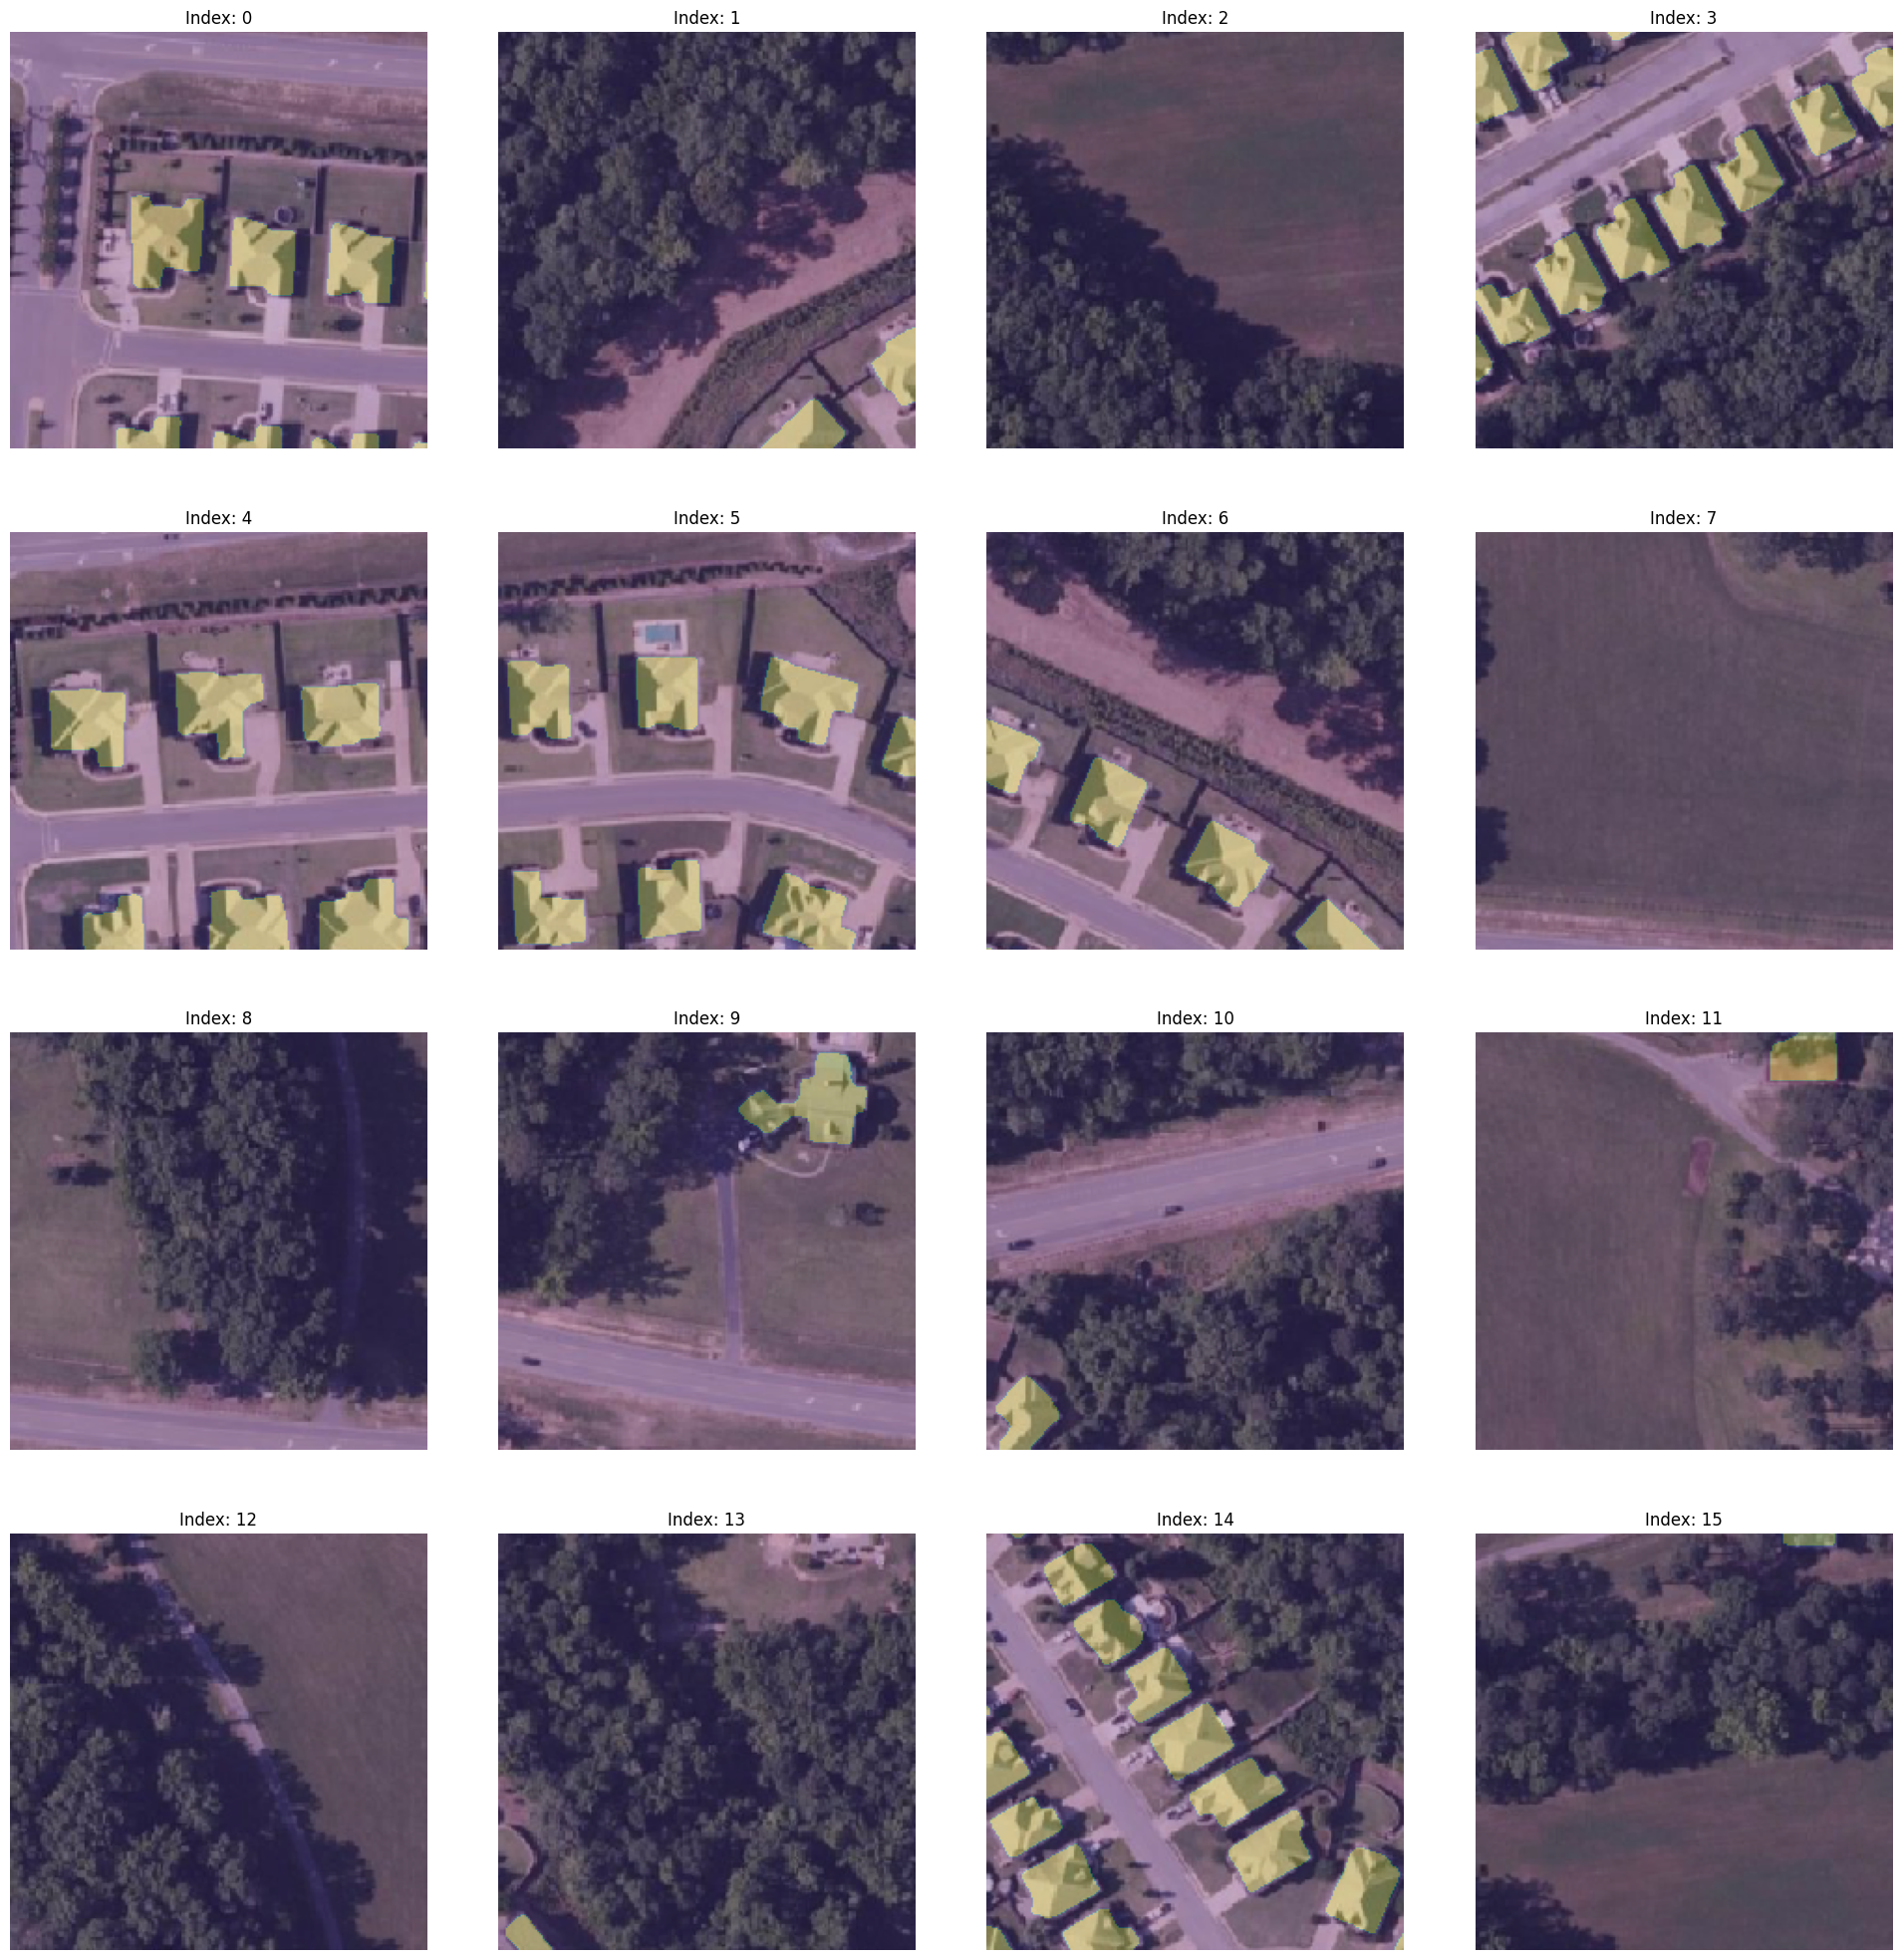

In [8]:

fig, axes = plt.subplots(4, 4, figsize=(25, 25))

for i, ax in enumerate(axes.flat):
    ax.imshow(origin[i])
    ax.imshow(masks[i], alpha=0.3)  # 원본 이미지를 투명도 조정하여 겹쳐서 출력
    ax.axis('off')
    ax.set_title(f'Index: {i}')


plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.show()


## Submission

In [9]:
result[:10], result_equal[:10]

(['19781 3 20002 10 20226 10 20256 8 20450 11 20479 10 20674 11 20703 10 20898 12 20926 11 21122 22 21149 12 21346 39 21570 39 21794 39 22018 39 22242 39 22466 39 22522 6 22690 39 22745 10 22914 39 22969 13 23138 39 23193 16 23247 3 23362 39 23417 18 23470 8 23586 39 23641 18 23694 11 23810 39 23865 20 23917 15 24034 38 24088 33 24141 18 24258 38 24312 34 24365 19 24482 38 24536 34 24589 21 24706 38 24760 34 24813 28 24930 38 24984 34 25037 33 25154 38 25208 34 25261 34 25378 38 25432 34 25485 34 25603 37 25656 34 25709 34 25827 37 25880 34 25933 34 26051 37 26104 34 26157 34 26275 37 26328 34 26381 34 26499 37 26552 34 26605 34 26723 37 26776 34 26828 35 26947 37 27000 34 27052 34 27171 36 27224 34 27276 34 27395 36 27448 34 27500 34 27619 36 27672 34 27724 34 27843 36 27896 34 27948 34 28000 1 28067 36 28120 34 28172 34 28224 1 28291 36 28343 35 28396 34 28448 1 28515 17 28537 14 28567 35 28620 34 28672 1 28739 16 28766 8 28791 35 28844 34 28896 1 28963 16 29015 34 29068 34 29120 1 2

In [ ]:
submit = pd.read_csv('backup/sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('./result.csv', index=False)